# Integrated Water Vapor Transport

## Setup

In [4]:
# Import statements
import xarray as xr
import matplotlib.pyplot as plt
from typing import List
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xskillscore as xs

plt.style.use("dark_background")


In [5]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def extract_variable(
    ds: List[xr.Dataset],
    varname: str,
    dim: xr.DataArray,
    times: List[str] | None = None,
) -> xr.DataArray:
    if times is None:
        return xr.concat(
            [d[varname] for d in ds],
            dim=dim,
        ).chunk({dim.name: -1})
    else:
        ds_list = []
        for t in times:
            ds_list.append(
                xr.concat(
                    [d[varname] for d in ds],
                    dim=dim,
                )
                .chunk({dim.name: -1})
                .sel(time=t)
            )
        return xr.concat(ds_list, dim="time")


In [6]:
# Read in 20-23Z initializations
wofs_all = [get_wofs_all(n) for n in range(20, 24, 1)]


In [7]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

lat_coarse = (
    wofs_all[0]
    .xlat_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)
lon_coarse = (
    wofs_all[0]
    .xlon_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
).rename("init")

## Calculate IVT

In [8]:
# Select times and extract variables from the list of WoFS initializations
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
u = extract_variable(wofs_all, "u", init, times=times)
v = extract_variable(wofs_all, "v", init, times=times)
q = extract_variable(wofs_all, "q", init, times=times)
p = extract_variable(wofs_all, "p", init, times=times) * 100  # convert to Pa
p = p.assign_attrs(dict(units="Pa"))

# multiply q by horizontal components of the wind
uq = u * q
vq = v * q

# calculate pressure layer thicknesses (dp)
dp = p.where(p > 30000).diff(dim="nz") * -1  # -1 because of coordinate orientation

# Vertically integrate along pressure coordinate using trapezoidal rule
ivt_u = (((uq.isel(nz=slice(1, None)) + uq.isel(nz=slice(None, -1))) / 2) * dp).sum(
    dim="nz"
) / 9.81
ivt_v = (((vq.isel(nz=slice(1, None)) + vq.isel(nz=slice(None, -1))) / 2) * dp).sum(
    dim="nz"
) / 9.81


## Get NYC rainfall

In [9]:
# Get the 01 to 02 UTC rainfall
rain12 = xr.concat(
    [
        w.rain.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")).sum(
            dim="time"
        )
        for w in wofs_all
    ],
    dim=init,
).chunk({"init": -1})


In [10]:
# Find the point closest to Central Park
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Extract the rainfall value
rain12_nyc = rain12.isel(lat=lat_ind, lon=lon_ind)


## Calculate correlation

In [64]:
# get correlation and p-values
corr_u = xs.spearman_r(ivt_u,rain12_nyc,dim=["ne","init"]).load()
pval_u = xs.spearman_r_p_value(ivt_u,rain12_nyc,dim=["ne","init"]).load()

corr_v = xs.spearman_r(ivt_v,rain12_nyc,dim=["ne","init"]).load()
pval_v = xs.spearman_r_p_value(ivt_v,rain12_nyc,dim=["ne","init"]).load()

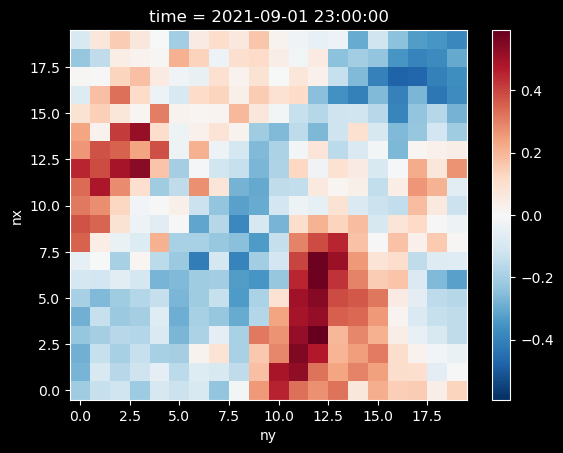

In [79]:
data_v[0].plot()

In [11]:
# Get data to plot
data_u = [corr_u.sel(time=t).squeeze() for t in times]
pdata_u = [pval_u.sel(time=t).squeeze() for t in times]
data_v = [corr_v.sel(time=t).squeeze() for t in times]
pdata_v = [pval_v.sel(time=t).squeeze() for t in times]
data = [*data_u,*data_v]
pdata = [*pval_u,*pval_v]
titles = [
    "Corr(IVT$_u$[23Z], RAIN[01-02Z,NYC])",
    "Corr(IVT$_u$[0Z], RAIN[01-02Z,NYC])",
    "Corr(IVT$_u$[01Z], RAIN[01-02Z,NYC])",
    "Corr(IVT$_v$[23Z], RAIN[01-02Z,NYC])",
    "Corr(IVT$_v$[0Z], RAIN[01-02Z,NYC])",
    "Corr(IVT$_v$[01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    2,
    3,
    figsize=(
        6,
        5,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes.flatten()):
    pc = ax.pcolormesh(
        lon_coarse,
        lat_coarse,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i],fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.05,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])

plt.show()


NameError: name 'corr_u' is not defined